##### Imports, Initializing, and Settings

In [40]:
import os, pandas as pd, glob, MetaTrader5 as mt5, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
from IPython.display import clear_output
mt5.initialize()
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_colwidth', 25)
pd.set_option('display.max_rows', 25)

##### Function Defintions

In [41]:
def timeframeChoice(timeframe:int):
    timeframeR = None
    if timeframe == 1:
        timeframeR = mt5.TIMEFRAME_M1
    elif timeframe==5:
        timeframeR = mt5.TIMEFRAME_M5
    elif timeframe==15:
        timeframeR = mt5.TIMEFRAME_M15
    elif timeframe==30:
        timeframeR = mt5.TIMEFRAME_M30
    elif timeframe==60:
        timeframeR = mt5.TIMEFRAME_H1
    elif timeframe==4:
        timeframeR = mt5.TIMEFRAME_H4
    elif timeframe==24:
        timeframeR = mt5.TIMEFRAME_D1
    return timeframeR

def get_price_data(symbol : str, timeframe : int, start : str, end : str):
    tf = timeframeChoice(timeframe)
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
    rates = mt5.copy_rates_range(symbol, tf, start_date, end_date)    
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.drop(columns=['tick_volume','real_volume', 'spread'],inplace=True)
    return df

def sell_chart(dataframe, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4.5))    
    if len(dataframe["Difference"].value_counts()) > 9:
        avg_neg_change = dataframe.groupby('Groups', observed=False)['max_negative_change'].mean()
        high_before_low = dataframe.groupby('Groups', observed=False)['high_before_low'].mean()
        average_mtl = dataframe.groupby('Groups', observed=False)['minutes_to_low'].mean()    
        frequency = []
        for k,v in sorted(dataframe['Groups'].value_counts().items()):
            frequency.append(v)
            
    else:
        avg_neg_change = dataframe.groupby('Difference', observed=False)['max_negative_change'].mean()
        high_before_low = dataframe.groupby('Difference', observed=False)['high_before_low'].mean()
        average_mtl = dataframe.groupby('Difference', observed=False)['minutes_to_low'].mean() 
        frequency = []
        for k,v in sorted(dataframe['Difference'].value_counts().items()):
            frequency.append(v)

    # Create a list containing the bin values as strings in order to supply to the graph's xlabel later
    avg_neg_list_keys = []
    for k,v in avg_neg_change.items():
        avg_neg_list_keys.append(str(k).replace("(","").replace("]",""))

    # Create graph for sells max(high_before_low.values)
    ax.bar(avg_neg_list_keys,high_before_low.values, color='green', zorder=2)
    ax.bar(avg_neg_list_keys,(avg_neg_change.values)*-1, color='red', zorder=2)
    for i, value in enumerate(avg_neg_change.values):
        # ax.text(i, 0.00025, round((high_before_low.values[i]*-1)/(avg_neg_change.values[i]), 3), 
        #         ha='center', va='bottom', color='black',rotation = 45, zorder=3)
        ax.text(i, -0.00025, round((avg_neg_change.values[i])/(high_before_low.values[i]), 3), 
                ha='center', va='top', color='black',rotation = 315, zorder=3)
        ax.text(i, 0.00025, round(average_mtl.values[i], 1), 
                ha='center', va='top', color='black', zorder=3)

    ax.text(0.05, 0.05, round(dataframe[dataframe['Difference'] < 0]['Difference'].corr(dataframe[dataframe['Difference'] < 0]['max_negative_change']), 3), 
            transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom')
    ax.text(0.95, 0.05, round(dataframe[dataframe['Difference'] > 0]['Difference'].corr(dataframe[dataframe['Difference'] > 0]['max_negative_change']), 3), 
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')
    ax.set_xticks(avg_neg_list_keys)
    ax.grid(True, axis='both', linestyle="--", color='grey', zorder=1)
    ax.set_facecolor('#e0e0e0')
    
def buy_chart(dataframe, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4.5))    
    if len(dataframe["Difference"].value_counts()) > 9:
        avg_pos_change = dataframe.groupby('Groups', observed=False)['max_positive_change'].mean()
        low_before_high = dataframe.groupby('Groups', observed=False)['low_before_high'].mean()
        average_mth = dataframe.groupby('Groups', observed=False)['minutes_to_high'].mean()
        frequency = []
        for k,v in sorted(dataframe['Groups'].value_counts().items()):
            frequency.append(v)

    else:
        avg_pos_change = dataframe.groupby('Difference', observed=False)['max_positive_change'].mean()
        low_before_high = dataframe.groupby('Difference', observed=False)['low_before_high'].mean()
        average_mth = dataframe.groupby('Difference', observed=False)['minutes_to_high'].mean()
        frequency = []
        for k,v in sorted(dataframe['Difference'].value_counts().items()):
            frequency.append(v)

    # Create a list containing the bin values in order to supply to the graphs later
    avg_neg_list_keys = []
    for k,v in avg_pos_change.items():
        avg_neg_list_keys.append(str(k).replace("(","").replace("]",""))

    # Create the graph for buys 
    ax.bar(avg_neg_list_keys,(low_before_high.values)*-1, color='red', zorder=2)
    ax.bar(avg_neg_list_keys,avg_pos_change.values, color='green', zorder=2)
    for i, value in enumerate(avg_pos_change.values):
        ax.text(i, 0.00025, round((avg_pos_change.values[i])/(low_before_high.values[i]), 3), 
                ha='center', va='bottom', color='black',rotation = 45, zorder=3)
        # ax.text(i, -0.00025, round((low_before_high.values[i]*-1)/(avg_pos_change.values[i]), 3), 
        #         ha='center', va='top', color='black',rotation = 315, zorder=3)
        ax.text(i, -0.00025, round(average_mth.values[i], 1), 
                ha='center', va='top', color='black', zorder=3)
        
    ax.text(0.05, 0.05, round(dataframe[dataframe['Difference'] < 0]['Difference'].corr(dataframe[dataframe['Difference'] < 0]['max_positive_change']), 3), transform=ax.transAxes,
        horizontalalignment='left', verticalalignment='bottom')
    ax.text(0.95, 0.05, round(dataframe[dataframe['Difference'] > 0]['Difference'].corr(dataframe[dataframe['Difference'] > 0]['max_positive_change']), 3), transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='bottom')
    new_labels = [f"{label} ({freq})" for label, freq in zip(avg_neg_list_keys, frequency)]    
    ax.set_xticks(avg_neg_list_keys)
    ax.set_xticklabels(new_labels, rotation=315)
    ax.grid(True, axis='both', linestyle="--", color='grey', zorder=1)
    ax.set_facecolor('#e0e0e0')


##### Grab CSV files & create dataframes from them, then plot 4 charts in a 2x2 subplot grid

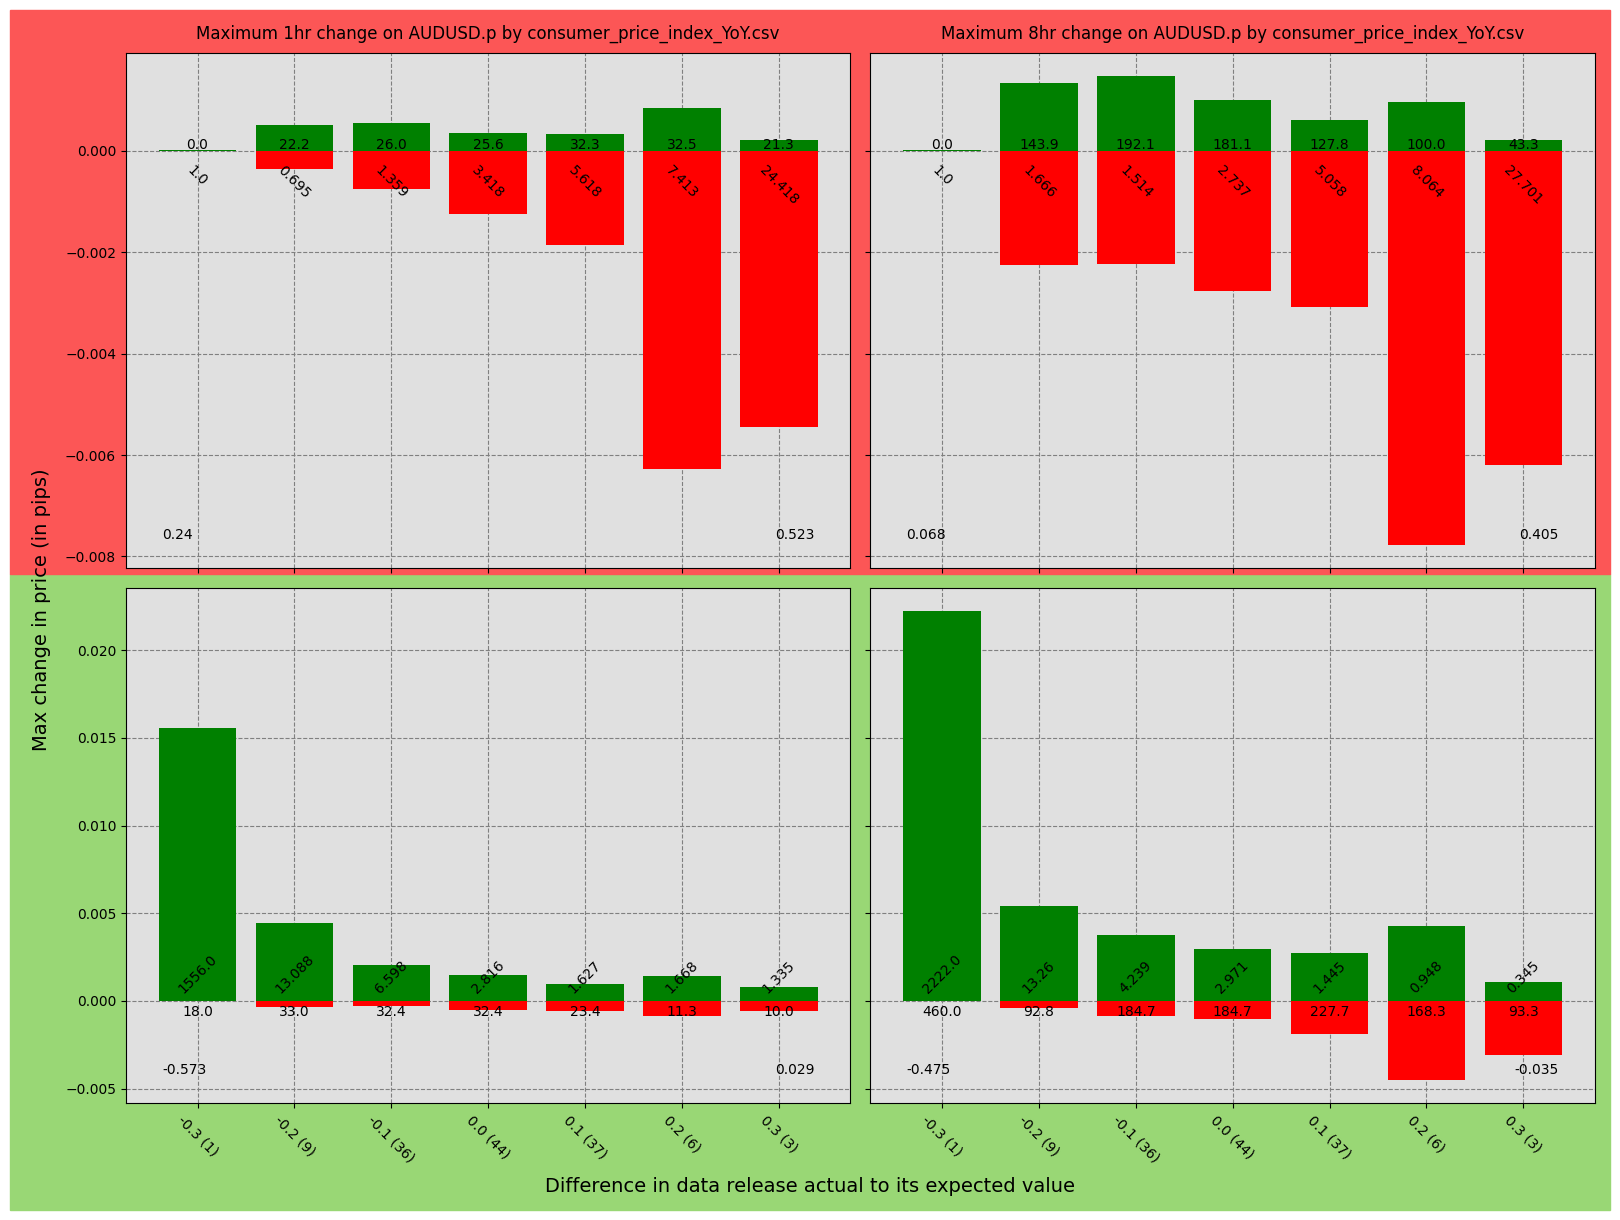

Program quit or no more pairs to analyze, have a good day!


In [42]:
forexsymbols =[]
currency = 'USD'
for i in mt5.symbols_get():
    if 'Forex .p' in i.path:
        if i.currency_profit == currency or i.currency_base == currency:
            forexsymbols.append(i.name)

folder_path = 'C:\\Files\\MTpython\\DataCSVs\\United_States/*'
csv_files = glob.glob(folder_path)
for file in csv_files:
    file_name = os.path.basename(file)
    # consumer_price_index_YoY.csv     nonfarm_payroll.csv
    if file_name == 'consumer_price_index_YoY.csv':
        data = pd.read_csv(file, index_col=0)
        data['Date'] = pd.to_datetime(data['Date'])
        stdev_plus2 = data['Difference'].describe()['mean'] + 2.5*(data['Difference'].describe()['std'])
        stdev_minus2 = data['Difference'].describe()['mean'] - 2.5*(data['Difference'].describe()['std']) 
        data = data.drop(data[(data['Difference'] > stdev_plus2) | (data['Difference'] < stdev_minus2)].index)

        for symbol in forexsymbols:
            data_1hr = data.copy()
            for i, r in data.iterrows():
                add_one_hour = timedelta(minutes=60)
                short_term_rates = get_price_data(symbol, 1, r['Date'], r['Date'] + add_one_hour)

                open = short_term_rates['open'].loc[0]
                data_1hr.loc[i, 'open'] = open

                max1h = short_term_rates['high'].max()
                idx_max = short_term_rates['high'].idxmax()
                max_pos_change_1hr = abs(max1h - open)

                min1h = short_term_rates['low'].min()
                idx_min = short_term_rates['low'].idxmin()
                max_neg_change_1hr = abs(min1h - open)
                
                data_1hr.loc[i, 'max_positive_change'] = max_pos_change_1hr
                data_1hr.loc[i, 'time_max'] = short_term_rates.loc[short_term_rates['high'] == max1h]['time'].values[0]
                data_1hr.loc[i, 'minutes_to_high'] = (data_1hr.loc[i, 'time_max'] - r['Date']).total_seconds() / 60
                if data_1hr.loc[i, 'minutes_to_high'] == 0 and (max_neg_change_1hr >= 3*max_pos_change_1hr):
                    data_1hr.loc[i, 'low_before_high'] = max_pos_change_1hr
                else:
                    data_1hr.loc[i, 'low_before_high'] = abs(short_term_rates.loc[:idx_max, 'low'].min() - open)

                data_1hr.loc[i, 'max_negative_change'] = max_neg_change_1hr
                data_1hr.loc[i, 'time_min'] = short_term_rates.loc[short_term_rates['low'] == min1h]['time'].values[0]
                data_1hr.loc[i, 'minutes_to_low'] = (data_1hr.loc[i, 'time_min'] - r['Date']).total_seconds() / 60
                if data_1hr.loc[i, 'minutes_to_low'] == 0 and (max_pos_change_1hr >= 3*max_neg_change_1hr):
                    data_1hr.loc[i, 'high_before_low'] = max_neg_change_1hr
                else:
                    data_1hr.loc[i, 'high_before_low'] = abs(short_term_rates.loc[:idx_min, 'high'].max() - open)

            if len(data_1hr["Difference"].value_counts()) > 9:
                bins = [0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 1]
                quantiles = []
                for i in bins:
                    quantiles.append(data_1hr['Difference'].quantile(i))
                data_1hr['Groups'] = pd.cut(data_1hr['Difference'], bins=quantiles, include_lowest=True, duplicates='drop')
    


            data_8hr = data.copy()
            for i, r in data.iterrows():
                add_eight_hours = timedelta(minutes=480)        
                long_term_rates = get_price_data(symbol, 5, r['Date'], r['Date'] + add_eight_hours)

                open = long_term_rates['open'].loc[0]
                data_8hr.loc[i, 'open'] = open

                max8h = long_term_rates['high'].max()
                idx_max = long_term_rates['high'].idxmax()
                max_pos_change_8hr = abs(max8h - open)

                min8h = long_term_rates['low'].min()
                idx_min = long_term_rates['low'].idxmin() 
                max_neg_change_8hr = abs(min8h - open)           

                data_8hr.loc[i, 'max_positive_change'] = max_pos_change_8hr
                data_8hr.loc[i, 'time_max'] = long_term_rates.loc[long_term_rates['high'] == max8h]['time'].values[0]
                data_8hr.loc[i, 'minutes_to_high'] = (data_8hr.loc[i, 'time_max'] - r['Date']).total_seconds() / 60
                if data_8hr.loc[i, 'minutes_to_high'] == 0 and (max_neg_change_8hr >= 3*max_pos_change_8hr):
                    data_8hr.loc[i, 'low_before_high'] = max_pos_change_8hr
                else:
                    data_8hr.loc[i, 'low_before_high'] = abs(long_term_rates.loc[:idx_max, 'low'].min() - open)

                data_8hr.loc[i, 'max_negative_change'] = max_neg_change_8hr
                data_8hr.loc[i, 'time_min'] = long_term_rates.loc[long_term_rates['low'] == min8h]['time'].values[0]
                data_8hr.loc[i, 'minutes_to_low'] = (data_8hr.loc[i, 'time_min'] - r['Date']).total_seconds() / 60
                if data_8hr.loc[i, 'minutes_to_low'] == 0 and (max_pos_change_8hr >= 3*max_neg_change_8hr):
                    data_8hr.loc[i, 'high_before_low'] = max_neg_change_8hr
                else:
                    data_8hr.loc[i, 'high_before_low'] = abs(long_term_rates.loc[:idx_min, 'high'].max() - open)     

            if len(data_8hr["Difference"].value_counts()) > 9:
                bins = [0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 1]
                quantiles = []
                for i in bins:
                    quantiles.append(data_8hr['Difference'].quantile(i))
                data_8hr['Groups'] = pd.cut(data_8hr['Difference'], bins=quantiles, include_lowest=True, duplicates='drop')            
            

            
            fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey='row')
            sell_chart(data_1hr, ax=axs[0, 0])
            sell_chart(data_8hr, ax=axs[0, 1])
            buy_chart(data_1hr, ax=axs[1, 0])
            buy_chart(data_8hr, ax=axs[1, 1])
            axs[0, 0].set_title('Maximum 1hr change on ' + symbol + ' by ' + file_name, pad=10)
            axs[0, 1].set_title('Maximum 8hr change on ' + symbol + ' by ' + file_name, pad=10)
            fig.text(0.5, 0.02, 'Difference in data release actual to its expected value', ha='center', va='center', fontsize=14)
            fig.text(0.02, 0.5, 'Max change in price (in pips)', ha='center', va='center', rotation='vertical', fontsize=14)
            center_y = axs[0, 0].get_position().y0
            fig.patches.extend([
                Rectangle((0, 0), 1, center_y, color='#99D775', alpha=1, transform=fig.transFigure, zorder=-1),
                Rectangle((0, center_y), 1, 1 - center_y, color='#fc5656', alpha=1, transform=fig.transFigure, zorder=-1)])
            plt.tight_layout(rect=[0.025, 0.025, 1, 1])
            plt.show()
            user_choice = input("Hit enter to continue or type \'done\' to quit")
            if user_choice != "" and user_choice.lower()!='done':
                clear_output()
                break
            elif user_choice.lower()=='done':
                break
            clear_output()
        if user_choice.lower() == "done":
                break
print("Program quit or no more pairs to analyze, have a good day!")

In [43]:
data_8hr.head(10)

,Date,Actual,Consensus,Difference,open,max_positive_change,time_max,minutes_to_high,low_before_high,max_negative_change,time_min,minutes_to_low,high_before_low
0,2023-11-14 15:30:00,3.2,3.3,-0.1,0.63708,0.01416,2023-11-14 22:25:00,415.0,0.00035,0.00035,2023-11-14 15:30:00,0.0,0.00035
1,2023-10-12 15:30:00,3.7,3.6,0.1,0.64058,0.00000,2023-10-12 15:30:00,0.0,0.00000,0.00987,2023-10-12 21:10:00,340.0,0.00000
2,2023-09-13 15:30:00,3.7,3.6,0.1,0.64040,0.00301,2023-09-13 19:35:00,245.0,0.00240,0.00240,2023-09-13 15:30:00,0.0,0.00035
3,2023-08-10 15:30:00,3.2,3.3,-0.1,0.65768,0.00398,2023-08-10 15:30:00,0.0,0.00000,0.00594,2023-08-10 23:30:00,480.0,0.00398
4,2023-07-12 15:30:00,3.0,3.1,-0.1,0.66888,0.01072,2023-07-12 20:00:00,270.0,0.00001,0.00001,2023-07-12 15:30:00,0.0,0.00001
5,2023-06-13 15:30:00,4.0,4.1,-0.1,0.67798,0.00270,2023-06-13 16:05:00,35.0,0.00174,0.00240,2023-06-13 21:40:00,370.0,0.00270
6,2023-05-10 15:30:00,4.9,5.0,-0.1,0.67504,0.00676,2023-05-10 15:55:00,25.0,0.00010,0.00047,2023-05-10 20:40:00,310.0,0.00676
7,2023-04-12 15:30:00,5.0,5.2,-0.2,0.66691,0.00542,2023-04-12 15:35:00,5.0,0.00002,0.00002,2023-04-12 15:30:00,0.0,0.00002
8,2023-03-14 15:30:00,6.0,6.0,0.0,0.66690,0.00267,2023-03-14 16:15:00,45.0,0.00339,0.00339,2023-03-14 15:30:00,0.0,0.00226
9,2023-02-14 15:30:00,6.4,6.2,0.2,0.69821,0.00450,2023-02-14 15:30:00,0.0,0.00428,0.00605,2023-02-14 16:30:00,60.0,0.00450
